# Covid19 Image Classification - Phase 1

__Abstract:__ Our Aim is to detect Covid19 from chest X-rays. The covid19 image dataset is small with 251 training and 60 test images belonging to 'NoFinding', 'Covid19' and 'Pneumonia' respectively. This dataset small and is insufficient to generalize. So for the purpoe of our project, in Phase-I we will first use NIH X-ray image data to retrain and finetune pretrained model architecture such as ResNet50V2 and MobileNetV2.

### Project Code Orginzation

Cookiecutter is a command-line utility that creates projects from cookiecutters (project templates), e.g. Python package projects, LaTeX documents, etc.
  
__Installed and created the project template using Cookiecutter:__  
Follow instructions from https://ericbassett.tech/cookiecutter-data-science-crash-course/



## Validating and pre-processing NIH X-ray metadata dataset  

Following instructions use make tool, run commands from from your terminal from your project folder
__Data Extraction:(execute only once)__  
Download and extract image data for the project  

    1. Download and unzip the NIH X-ray images in data/raw    
        Run: make get_nih_images   

__Data Validation:(execute only once)__  

    3. Validate Dataset (rename columns and delete patient record with age greater than 100)   
        Run: make validate_nih_images   

__Data Prepartion:(execute only once)__  

    4. Prepare Dataset (add path attribute, split dataset into train and validation dataset)
        Run: make prepare_nih_images

This proudces the three output files in processed folder:
    1. prepared_data_entry_2017.csv (full dataset)
    2. prepared_train_data_entry_2017.csv (train_dataset)
    3. prepared_valid_data_entry_2017.csv (validation_dataset)

Next, we use prepared_train_data_entry_2017.csv and prepared_valid_data_entry_2017.csv files to retrain CNN model architectures pre-trained using IMAGENET database

In [1]:
# common imports
import os
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from glob import glob
from pathlib import Path
from functools import partial

from sklearn.model_selection import train_test_split

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# prevent VRAM occupied
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


#change working directory  - as the images are located in data/raw in the project folder 
os.chdir("../")

# Import functions for trianing the model
%load_ext autoreload
%autoreload 2
import src.models.train_model as train_model

# load tensorboard extension
%reload_ext tensorboard

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Constants
SEED =42
IMAGE_SIZE = (224,224)
IMAGE_SHAPE = (224,224,3)
BATCH_SIZE = 32
SHUFFLE = True
TARGET_WIDTH= 224
TARGET_HEGIHT =224
NUM_CLASSES = 15 # number of ClassesNUM
NUM_EPOCHS = 2
PRETRAINED_MODELS = ['ResNet50V2', 'MobileNetV2', 'VGG16']
log_folder = 'logs' # logs folder

In [3]:
nih_xrays_train_df = pd.read_csv('data/processed/prepared_train_data_entry_2017.csv')
nih_xrays_valid_df = pd.read_csv('data/processed/prepared_valid_data_entry_2017.csv')


In [4]:
# Get fourteen unique diagnosis
# It is a function that takes a series of iterables and returns one iterable
# The asterisk "*" is used in Python to define a variable number of arguments. 
# The asterisk character has to precede a variable identifier in the parameter list 
from itertools import chain
all_labels = np.unique(list(chain(*nih_xrays_train_df['finding_label'].map(lambda x: x.split('|')).tolist())))
# remove the empty label
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Infiltration', 'Mass', 'NoFinding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


## Preprocess Images

In [5]:
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator



image_data_gen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True, #Boolean. Set each sample mean to 0.
    samplewise_std_normalization = False, #Boolean. Divide each input by its std.
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    horizontal_flip = True, #Boolean. Randomly flip inputs horizontally.
    vertical_flip = False,  #Boolean. Randomly flip inputs vertically.
    zca_whitening=False,  # apply ZCA whitening
    height_shift_range= 0.05, #float: fraction of total height, if < 1, or pixels if >= 1.
    width_shift_range=0.1,  #float: fraction of total height, if < 1, or pixels if >= 1.
    rotation_range=20, #Int. Degree range for random rotations. 0 -180 degrees
    shear_range = 0.1, #Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    fill_mode = 'nearest', #One of {"constant", "nearest", "reflect" or "wrap"}. Default is 'nearest'. 
    zoom_range=0.15) #Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]

#Takes the dataframe and the path to a directory + generates batches.
train_generator = image_data_gen.flow_from_dataframe(
            dataframe=nih_xrays_train_df,
            directory=None, #string, path to the directory to read images from. 
                            #If None, data in x_col column should be absolute paths.
            x_col='path', #string, column in dataframe that contains the filenames (or absolute paths if directory is None).
            y_col='finding_label', #string or list, column/s in dataframe that has the target data.
    
            class_mode="categorical", #one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical". 
                              # Mode for yielding the targets: "raw": numpy array of values in y_col column(s),
            classes=all_labels,
            #color_mode='grayscale',
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE,
            seed=SEED,
            target_size= IMAGE_SIZE)

#Takes the dataframe and the path to a directory + generates batches.
valid_generator = image_data_gen.flow_from_dataframe(
            dataframe=nih_xrays_valid_df,
            directory=None, #string, path to the directory to read images from. 
                            #If None, data in x_col column should be absolute paths.
            x_col='path', #string, column in dataframe that contains the filenames (or absolute paths if directory is None).
            y_col='finding_label', #string or list, column/s in dataframe that has the target data.
    
            class_mode="categorical", #one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical". 
                              # Mode for yielding the targets: "raw": numpy array of values in y_col column(s),
            classes=all_labels,
            #color_mode='grayscale',
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE,
            seed=SEED,
            target_size= IMAGE_SIZE)

Found 72862 validated image filenames belonging to 14 classes.
Found 18340 validated image filenames belonging to 14 classes.


### Visualize Images

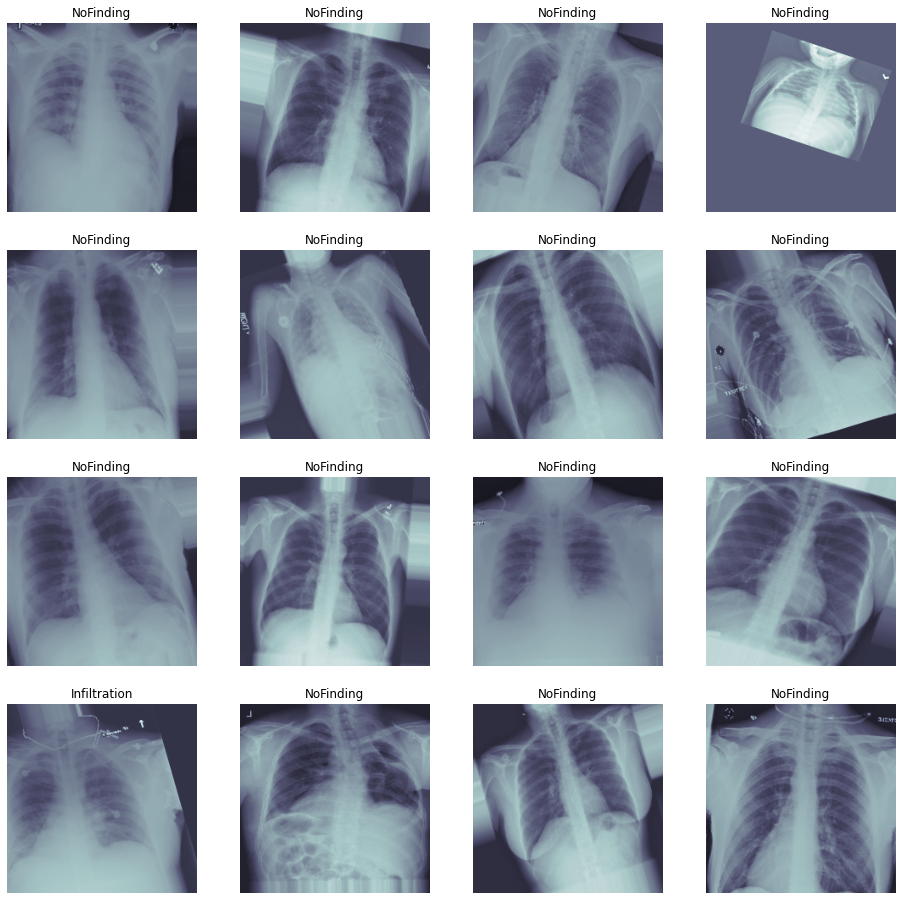

In [6]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Resenet50v2

## MultiClass Classification

In [7]:
freeze_layers = True
model_name = 'ResNet50V2'
num_classes =14
activation =keras.activations.softmax
learning_rate = 0.01
base_model = train_model.get_base_model_with_new_toplayer(base_model=model_name,
                                                          freeze_layers = freeze_layers, 
                                                          num_classes = num_classes,
                                                          activation=activation,
                                                          learning_rate = learning_rate,
                                                          input_shape = IMAGE_SHAPE)

print("\n")
print(f'{model_name} Training and Validation: ')
    
history = train_model.fit_model(base_model, train_generator, 
        valid_generator, 
        num_epochs=NUM_EPOCHS)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



ValueError: Unknown optimizer: softmax. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.